In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
import re
loss_type = "bce"

In [2]:
SARCOPENIA_ABSENT = 0
SARCOPENIA_PRESENT = 1

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomAffine(15, translate=[0.05, 0.05], scale=[0.9, 1.1]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Custom dataset class
class CustomDataSet(Dataset):
    def __init__(self, main_dir, data_dirs, transform):
        self.transform = transform
        self.main_dir = main_dir
        self.total_imgs = data_dirs
        self.abn_pattern = re.compile(r"abn\d+")  # Matches "abn" followed by one or more digits
        self.norm_pattern = re.compile(r"norm\d+")  # Matches "norm" followed by one or more digits

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        
        # Determine label based on image location
        if self.abn_pattern.search(img_loc):
            label = SARCOPENIA_PRESENT
        elif self.norm_pattern.search(img_loc):
            label = SARCOPENIA_ABSENT
        else:
            raise ValueError("Invalid label in img_loc")
        
        return tensor_image, label

# Load data
main_dir = "./0822data/256png/"
all_files = os.listdir(main_dir)
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_dataset = CustomDataSet(main_dir, train_files, transform_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

test_dataset = CustomDataSet(main_dir, test_files, transform_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)


In [3]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
if loss_type == "mse":
    model.fc = nn.Linear(num_ftrs, 1)
elif loss_type == "bce":
    model.fc = nn.Linear(num_ftrs, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model is on CUDA device:", next(model.parameters()).is_cuda)

D:\jupiter\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\jupiter\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model is on CUDA device: True


In [4]:
criterion = nn.CrossEntropyLoss() if loss_type == "bce" else nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Train model
model.train()
num_epochs = 15
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    scheduler.step()
    train_accuracy = 100 * train_correct / train_total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Evaluate model
model.eval()
test_features = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_features.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


Epoch 1/15, Train Loss: 0.8337, Train Accuracy: 59.30%
Epoch 2/15, Train Loss: 0.6937, Train Accuracy: 60.35%
Epoch 3/15, Train Loss: 0.7277, Train Accuracy: 61.40%
Epoch 4/15, Train Loss: 0.6442, Train Accuracy: 63.16%
Epoch 5/15, Train Loss: 0.6173, Train Accuracy: 65.61%
Epoch 6/15, Train Loss: 0.5968, Train Accuracy: 65.96%
Epoch 7/15, Train Loss: 0.5875, Train Accuracy: 68.07%
Epoch 8/15, Train Loss: 0.5691, Train Accuracy: 70.53%
Epoch 9/15, Train Loss: 0.5731, Train Accuracy: 67.72%
Epoch 10/15, Train Loss: 0.5840, Train Accuracy: 67.72%
Epoch 11/15, Train Loss: 0.5553, Train Accuracy: 68.77%
Epoch 12/15, Train Loss: 0.5547, Train Accuracy: 70.88%
Epoch 13/15, Train Loss: 0.5507, Train Accuracy: 70.88%
Epoch 14/15, Train Loss: 0.5651, Train Accuracy: 70.18%
Epoch 15/15, Train Loss: 0.5410, Train Accuracy: 70.18%


In [5]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(test_features, test_labels)

# Make predictions using kNN
predicted_labels_knn = knn_classifier.predict(test_features)

# Calculate accuracy of kNN predictions
accuracy_knn = accuracy_score(test_labels, predicted_labels_knn)
print("Accuracy (kNN):", accuracy_knn)

Accuracy (kNN): 0.875


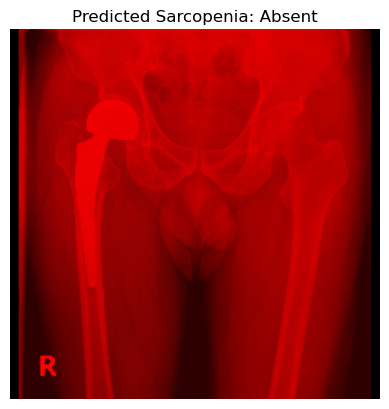

In [6]:
import matplotlib.pyplot as plt 
def test_image(img_path):
    # Load and transform the image
    image = Image.open(img_path).convert("RGB")
    transformed_image = transform_test(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Pass the image through the model
    model.eval()
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted_label = torch.max(output, 1)

    # Convert predicted label to sarcopenia present or absent
    predicted_sarcopenia = "Present" if predicted_label.item() == SARCOPENIA_PRESENT else "Absent"

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted Sarcopenia: {predicted_sarcopenia}")
    plt.axis('off')
    plt.show()

# Test a particular image
img_path = "./0822data/256png/norm5.png"  # Replace this with the path to the image you want to test
test_image(img_path)